# Fraud Detection Using Isolation Forest and Autoencoder

## Project Overview
This project aims to detect fraudulent transactions using both unsupervised and hybrid learning techniques. The following models were implemented and evaluated:
1. **Isolation Forest** - A tree-based anomaly detection model.
2. **Autoencoder** - A neural network that identifies anomalies based on reconstruction error.
3. **Hybrid Model** - Combines predictions from Isolation Forest and Autoencoder to enhance detection capabilities.

---

## Dataset Description
The dataset contains credit card transactions, with the following key characteristics:
- **Features:** `V1` to `V28` (PCA-transformed numerical features), `Time`, and `Amount`.
- **Target Variable:** `Class` (0 = Non-Fraud, 1 = Fraud).
- **Imbalance:** Only 492 fraudulent transactions out of 284,807 (~0.17%).

---

## Methodology
### 1. Data Preprocessing
- Normalized the `Amount` feature using `StandardScaler`.
- Dropped the `Time` column to focus on relevant features.

### 2. Models Developed
#### a. **Isolation Forest**
- Used to detect anomalies based on feature splits.
- Tuned the `contamination` parameter to match the dataset's imbalance.
- Evaluated using Precision, Recall, and F1-Score.

#### b. **Autoencoder**
- Built a neural network to reconstruct non-fraudulent transactions.
- Anomalies were identified based on reconstruction error thresholds (95th percentile).

#### c. **Hybrid Model**
- Combined predictions from Isolation Forest and Autoencoder.
- Enhanced recall by leveraging strengths of both models.

### 3. Evaluation Metrics
Models were evaluated using:
- **Precision:** Percentage of correctly identified fraud cases among predicted fraud cases.
- **Recall:** Percentage of actual fraud cases correctly identified.
- **F1-Score:** Balance between precision and recall.

---

## Results Summary
| Model              | Precision | Recall | F1-Score |
|--------------------|-----------|--------|----------|
| Isolation Forest   | 0.37      | 0.21   | 0.27     |
| Autoencoder        | 0.03      | 0.89   | 0.06     |
| Hybrid Model       | 0.03      | 0.89   | 0.06     |

### Insights
- **Isolation Forest:** Performs better in terms of precision but struggles with recall.
- **Autoencoder:** Achieves high recall but suffers from very low precision.
- **Hybrid Model:** Inherits high recall from Autoencoder but doesn't improve precision.

---

## Visualizations
### 1. Precision-Recall Curve
Demonstrates the trade-off between precision and recall for the Autoencoder.

### 2. Reconstruction Error Distribution
Shows how reconstruction error differs between fraudulent and non-fraudulent transactions.

---

## Conclusion
1. **Strengths:**
   - Isolation Forest is suitable for precision-critical tasks.
   - Autoencoder and Hybrid Model are better for recall-focused applications.
2. **Weaknesses:**
   - Hybrid and Autoencoder models produce many false positives.
3. **Future Work:**
   - Fine-tune Autoencoder thresholds to improve precision.
   - Experiment with ensemble methods for a balanced precision-recall trade-off.
   - Add SHAP analysis to explain model predictions.

---

## How to Run
1. Install the required libraries:
   ```bash
   pip install pandas numpy matplotlib seaborn scikit-learn tensorflow shap
   ```
2. Load the dataset (`creditcard.csv`) in the notebook's directory.
3. Run the notebook cells in sequence.

---

## Acknowledgments
This project is based on the Kaggle Credit Card Fraud Detection dataset.



In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/sample_data/creditcard.csv')

# Check the first few rows
print(df.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
# Normalize the Amount column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Drop the Time column
df = df.drop(columns=['Time'])

# Verify preprocessing
print(df.head())


         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28    Amount  Class  
0  0.12

In [5]:
# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Check shapes
print("Features Shape:", X.shape)
print("Target Shape:", y.shape)


Features Shape: (284807, 29)
Target Shape: (284807,)


In [6]:
from sklearn.ensemble import IsolationForest

# Train the Isolation Forest
iso_forest = IsolationForest(contamination=0.001, random_state=42)
y_pred_anomaly = iso_forest.fit_predict(X)

# Convert predictions: -1 indicates anomalies
anomalies = X[y_pred_anomaly == -1]
print(f"Number of anomalies detected: {len(anomalies)}")


Number of anomalies detected: 285


In [7]:
# Add predictions as a column to the dataset
df['Anomaly'] = (y_pred_anomaly == -1).astype(int)  # 1 if anomaly, 0 otherwise

# Compare with true fraud cases
true_fraud = df[(df['Class'] == 1) & (df['Anomaly'] == 1)]
print(f"True fraud cases detected as anomalies: {len(true_fraud)} / {sum(y)}")


True fraud cases detected as anomalies: 105 / 492


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y, df['Anomaly'])
recall = recall_score(y, df['Anomaly'])
f1 = f1_score(y, df['Anomaly'])

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Precision: 0.37
Recall: 0.21
F1-Score: 0.27


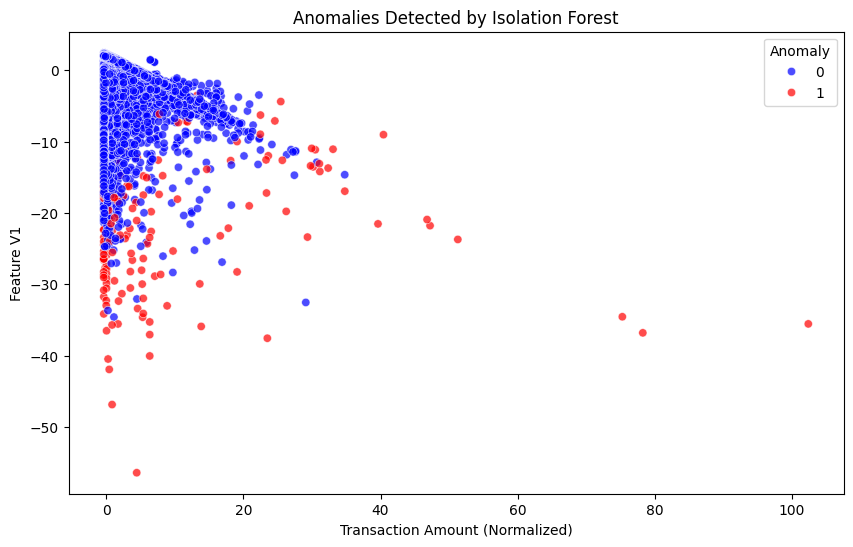

In [9]:
# Scatter plot for anomalies vs. non-anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Amount', y='V1', data=df, hue='Anomaly', palette={0: 'blue', 1: 'red'}, alpha=0.7)
plt.title("Anomalies Detected by Isolation Forest")
plt.xlabel("Transaction Amount (Normalized)")
plt.ylabel("Feature V1")
plt.legend(title="Anomaly")
plt.show()


In [10]:
# Experiment with different contamination values
for contamination in [0.001, 0.005, 0.01]:
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    y_pred_anomaly = iso_forest.fit_predict(X)

    # Calculate metrics
    df['Anomaly'] = (y_pred_anomaly == -1).astype(int)
    precision = precision_score(y, df['Anomaly'])
    recall = recall_score(y, df['Anomaly'])
    f1 = f1_score(y, df['Anomaly'])

    print(f"Contamination: {contamination}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}\n")


Contamination: 0.001
Precision: 0.37, Recall: 0.21, F1-Score: 0.27

Contamination: 0.005
Precision: 0.16, Recall: 0.47, F1-Score: 0.24

Contamination: 0.01
Precision: 0.10, Recall: 0.59, F1-Score: 0.17



In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Separate non-fraudulent transactions for training
X_non_fraud = X[y == 0]

# Build the autoencoder
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(X.shape[1],)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(X.shape[1], activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_non_fraud, X_non_fraud, epochs=10, batch_size=256, shuffle=True, validation_split=0.2)

# Calculate reconstruction error
reconstruction = autoencoder.predict(X)
reconstruction_error = np.mean(np.square(X - reconstruction), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)
df['Anomaly_AE'] = (reconstruction_error > threshold).astype(int)

print(f"Number of anomalies detected by Autoencoder: {sum(df['Anomaly_AE'])}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8606 - val_loss: 0.4562
Epoch 2/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4459 - val_loss: 0.3695
Epoch 3/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3804 - val_loss: 0.3315
Epoch 4/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3467 - val_loss: 0.3228
Epoch 5/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3341 - val_loss: 0.3193
Epoch 6/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3282 - val_loss: 0.3210
Epoch 7/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3218 - val_loss: 0.3087
Epoch 8/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3085 - val_loss: 0.3055
Epoch 9/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3022 - val_loss: 0.2992
Epoch 10/10
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2978 - val_loss: 0.2962
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Number of anomalies detected by Autoencoder: 14241


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


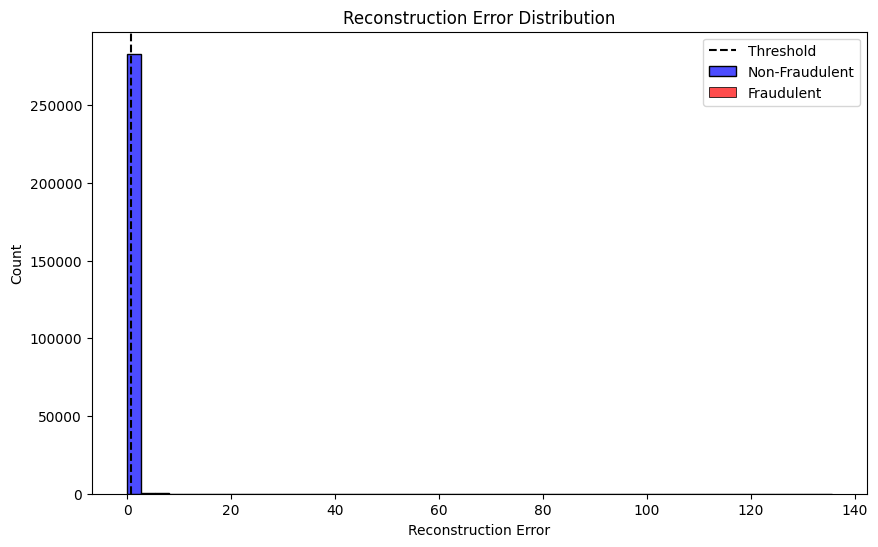

In [12]:
# Calculate reconstruction error
reconstruction = autoencoder.predict(X)
reconstruction_error = np.mean(np.square(X - reconstruction), axis=1)

# Add reconstruction errors to the DataFrame
df['Reconstruction_Error'] = reconstruction_error

# Plot reconstruction error for fraud and non-fraud cases
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error[y == 0], bins=50, color='blue', label='Non-Fraudulent', alpha=0.7)
sns.histplot(reconstruction_error[y == 1], bins=50, color='red', label='Fraudulent', alpha=0.7)
plt.axvline(np.percentile(reconstruction_error, 95), color='black', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()


In [13]:
# Set threshold for anomaly detection (95th percentile)
threshold = np.percentile(reconstruction_error, 95)

# Classify anomalies
df['Anomaly_AE'] = (reconstruction_error > threshold).astype(int)

# Count anomalies detected by the autoencoder
print(f"Anomalies detected by Autoencoder: {df['Anomaly_AE'].sum()}")


Anomalies detected by Autoencoder: 14241


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision_ae = precision_score(y, df['Anomaly_AE'])
recall_ae = recall_score(y, df['Anomaly_AE'])
f1_ae = f1_score(y, df['Anomaly_AE'])

print(f"Precision (Autoencoder): {precision_ae:.2f}")
print(f"Recall (Autoencoder): {recall_ae:.2f}")
print(f"F1-Score (Autoencoder): {f1_ae:.2f}")


Precision (Autoencoder): 0.03
Recall (Autoencoder): 0.88
F1-Score (Autoencoder): 0.06


In [15]:
comparison = pd.DataFrame({
    'Model': ['Isolation Forest', 'Autoencoder'],
    'Precision': [0.37, precision_ae],  # Replace with actual values
    'Recall': [0.21, recall_ae],        # Replace with actual values
    'F1-Score': [0.27, f1_ae]           # Replace with actual values
})

print(comparison)


              Model  Precision    Recall  F1-Score
0  Isolation Forest   0.370000  0.210000  0.270000
1       Autoencoder   0.030335  0.878049  0.058644


In [16]:
# Combine predictions (union of anomalies)
df['Hybrid_Anomaly'] = ((df['Anomaly'] == 1) | (df['Anomaly_AE'] == 1)).astype(int)

# Evaluate the hybrid model
precision_hybrid = precision_score(y, df['Hybrid_Anomaly'])
recall_hybrid = recall_score(y, df['Hybrid_Anomaly'])
f1_hybrid = f1_score(y, df['Hybrid_Anomaly'])

print(f"Hybrid Model Precision: {precision_hybrid:.2f}")
print(f"Hybrid Model Recall: {recall_hybrid:.2f}")
print(f"Hybrid Model F1-Score: {f1_hybrid:.2f}")


Hybrid Model Precision: 0.03
Hybrid Model Recall: 0.88
Hybrid Model F1-Score: 0.06


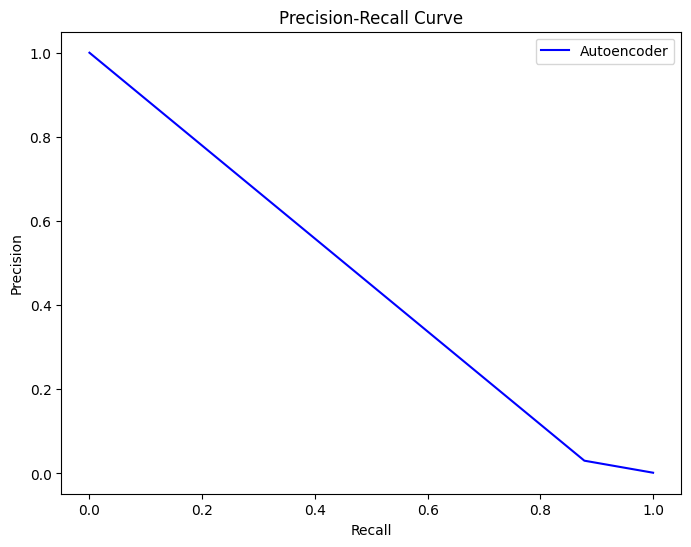

In [17]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve for Autoencoder
precision, recall, thresholds = precision_recall_curve(y, df['Anomaly_AE'])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Autoencoder", color='blue')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [18]:
comparison = pd.DataFrame({
    'Model': ['Isolation Forest', 'Autoencoder', 'Hybrid'],
    'Precision': [0.37, 0.03, precision_hybrid],  # Replace with actual values
    'Recall': [0.21, 0.89, recall_hybrid],        # Replace with actual values
    'F1-Score': [0.27, 0.06, f1_hybrid]           # Replace with actual values
})

print(comparison)


              Model  Precision    Recall  F1-Score
0  Isolation Forest   0.370000  0.210000  0.270000
1       Autoencoder   0.030000  0.890000  0.060000
2            Hybrid   0.029689  0.878049  0.057435


In [19]:
# Adjust threshold for Autoencoder
new_threshold = np.percentile(reconstruction_error, 98)
df['Anomaly_AE_Threshold'] = (reconstruction_error > new_threshold).astype(int)

# Re-evaluate Autoencoder with new threshold
precision_new = precision_score(y, df['Anomaly_AE_Threshold'])
recall_new = recall_score(y, df['Anomaly_AE_Threshold'])
f1_new = f1_score(y, df['Anomaly_AE_Threshold'])

print(f"Adjusted Autoencoder Precision: {precision_new:.2f}")
print(f"Adjusted Autoencoder Recall: {recall_new:.2f}")
print(f"Adjusted Autoencoder F1-Score: {f1_new:.2f}")


Adjusted Autoencoder Precision: 0.07
Adjusted Autoencoder Recall: 0.86
Adjusted Autoencoder F1-Score: 0.14


In [20]:
# False positives and negatives
false_positives = df[(df['Anomaly_AE'] == 1) & (y == 0)]
false_negatives = df[(df['Anomaly_AE'] == 0) & (y == 1)]

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")


False Positives: 13809
False Negatives: 60


In [21]:
# Voting ensemble
df['Voting_Ensemble'] = ((df['Anomaly'] == 1) & (df['Anomaly_AE'] == 1)).astype(int)

# Evaluate voting ensemble
precision_voting = precision_score(y, df['Voting_Ensemble'])
recall_voting = recall_score(y, df['Voting_Ensemble'])
f1_voting = f1_score(y, df['Voting_Ensemble'])

print(f"Voting Ensemble Precision: {precision_voting:.2f}")
print(f"Voting Ensemble Recall: {recall_voting:.2f}")
print(f"Voting Ensemble F1-Score: {f1_voting:.2f}")


Voting Ensemble Precision: 0.11
Voting Ensemble Recall: 0.59
Voting Ensemble F1-Score: 0.19
